#PROGETTO DI CALCOLO NUMERICO A.A. 2021/2022

Gruppo composto da:


*   Apollonio Francesco
*   Bianchi Andrea
*   Mazzetti Francesca

In questo colab è illustrato il codice sorgente utilizzato per lo svolgimento dei test richiesti.

## Funzioni utilizzate

In questa sezione troviamo tutte le funzioni utilizzate; in particolare:
  

*   Funzioni necessarie per la correzione delle immagini con i differenti metodi richiesti.

*   Funzioni utili al plotting delle figure risultanti nonchè dei rispettivi valori tecnici ( PSNR, MSE ).



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, metrics
from scipy.optimize import minimize
from numpy import fft

# Creazione Kernel Gaussiano di dimensione kerneln e deviazione standard sigma
def gaussian_kernel(kernlen, sigma):
  x = np.linspace(- (kernlen // 2), kernlen // 2, kernlen)
  # Kernel Gaussiano unidmensionale
  kern1d = np.exp(- 0.5 * (x**2 / sigma))
  # Kernel Gaussiano bidimensionale
  kern2d = np.outer(kern1d, kern1d)
  # Normalizzazione
  return kern2d / kern2d.sum()


# Calcolo FFT del kernel 'K' di dimensioni 'd' con opportuno padding necessario a far combaciare la dimensione di 'shape'

def psf_fft(K, d, shape):
  '''
  @param K: the gaussian kernel
  @param d: the len of the gaussian kernel (kernlen)
  '''
  # Zero padding
  K_p = np.zeros(shape)
  K_p[:d, :d] = K
  # Shift
  p = d // 2
  K_pr = np.roll(np.roll(K_p, -p, 0), -p, 1)
  # Calcolo FFT
  K_otf = fft.fft2(K_pr)
  return K_otf

# Moltiplicazione per A
def A(x, K):
  x = fft.fft2(x)
  return np.real(fft.ifft2(K * x))

# Moltiplicazione per A trasposta
def AT(x, K):
  x = fft.fft2(x)
  return np.real(fft.ifft2(np.conj(K) * x))


''' Funzioni per implementazione del metodo del gradiente visto a lezione ( quarto laboratorio )'''

# Procedura di backtracking per la scelta della dimensione del passo
def next_step(x, grad, f_reg):
  alpha = 1.1
  rho = 0.5
  c1 = 0.25
  p = -grad
  j = 0
  jmax = 10
  while ((f_reg(x.reshape(x.size)+alpha*p) > f_reg(x)+c1*alpha*grad.T@p) and j < jmax):
    alpha = rho*alpha
    j += 1
  if (j > jmax):
    return -1
  else:
    return alpha


# Funzione minimize implementata secondo quanto visto a lezione ( quarto laboratorio )
def custom_minimize(x0, b, MAXITERATION, ABSOLUTE_STOP, f_reg, df_reg):
  norm_grad_list = np.zeros((1, MAXITERATION))
  function_eval_list = np.zeros((1, MAXITERATION))
  error_list = np.zeros((1, MAXITERATION))

  # inizializzazione
  x_last = np.copy(x0)

  k = 0

  function_eval_list[k] = f_reg(x_last)
  error_list[k] = np.linalg.norm(x_last - b)
  norm_grad_list[k] = np.linalg.norm(df_reg(x_last))

  while (np.linalg.norm(df_reg(x_last)) > ABSOLUTE_STOP and k < MAXITERATION - 1):
    k = k + 1
    # la direzione è data dal gradiente dell'ultima iterazione
    grad = df_reg(x_last)

    # backtracking step
    step = next_step(x_last, grad, f_reg)


    if (step == -1):
      print('non convergente')
      return (k)  # no convergence

    x_last = x_last - (step * grad).reshape(512, 512)

    function_eval_list[0][k] = f_reg(x_last)
    error_list[0][k] = np.linalg.norm(x_last - b)
    norm_grad_list[0][k] = np.linalg.norm(df_reg(x_last))

  function_eval_list = function_eval_list[0][:k + 1]
  error_list = error_list[0][:k + 1]
  norm_grad_list = norm_grad_list[0][:k + 1]

  return (x_last, norm_grad_list, function_eval_list, error_list, k)


eps = 1e-2


'''Funzioni utili all'implementazione del nuovo termine di regolarizzazione: Variazione Totale '''

# Variazione totale
def totvar(x):
  # Calcola il gradiente di x
  dx, dy = np.gradient(x)
  n2 = np.square(dx) + np.square(dy)

  # Calcola la variazione totale di x
  tv = np.sqrt(n2 + eps ** 2).sum()
  return tv

# Gradiente della variazione totale
def grad_totvar(x):
  # Calcola il numeratore della frazione
  dx, dy = np.gradient(x)

  # Calcola il denominatore della frazione
  n2 = np.square(dx) + np.square(dy)
  den = np.sqrt(n2 + eps ** 2)

  # Calcola le due componenti di F dividendo il gradiente per il denominatore
  Fx = dx / den
  Fy = dy / den

  # Calcola la derivata orizzontale di Fx
  dFdx = np.gradient(Fx, axis=0)

  # Calcola la derivata verticale di Fy
  dFdy = np.gradient(Fy, axis=1)

  # Calcola la divergenza
  div = (dFdx + dFdy)

  # Restituisci il valore del gradiente della variazione totale
  return -div

# Procedura di backtracking per la scelta della dimensione del passo specifica per il nuovo termine di regolarizzazione
def next_step_totvar(x, grad, f_totvar):
  alpha = 1.1
  rho = 0.5
  c1 = 0.25
  p = -grad
  j = 0
  jmax = 10
  while ((f_totvar(x.reshape(x.size) + alpha * p) > f_totvar(x) + c1 * alpha * grad.T@p) and j < jmax):
    alpha = rho * alpha
    j += 1
  if (j > jmax):
    return -1
  else:
    return alpha


# Funzione che implementa il metodo del gradiente come visto a lezione specifica per il nuovo termine di regolarizzazione
def totvar_minimize(x0, b, MAXITERATION, ABSOLUTE_STOP, f_totvar, df_totvar):

  norm_grad_list = np.zeros((1, MAXITERATION))
  function_eval_list = np.zeros((1, MAXITERATION))
  error_list = np.zeros((1, MAXITERATION))

  # Inizializzazione
  x_last = np.copy(x0)

  k = 0

  function_eval_list[k] = f_totvar(x_last)
  error_list[k] = np.linalg.norm(x_last - b)
  norm_grad_list[k] = np.linalg.norm(df_totvar(x_last))

  while (np.linalg.norm(df_totvar(x_last)) > ABSOLUTE_STOP and k < MAXITERATION - 1):
    k = k + 1
    grad = df_totvar(x_last)

    # backtracking step
    step = next_step_totvar(x_last, grad, f_totvar)


    if (step == -1):
      print('non convergente')
      return (k)  # nessuna convergenza

    x_last = x_last - (step * grad).reshape(512, 512)

    function_eval_list[0][k] = f_totvar(x_last)
    error_list[0][k] = np.linalg.norm(x_last - b)
    norm_grad_list[0][k] = np.linalg.norm(df_totvar(x_last))

  function_eval_list = function_eval_list[0][:k + 1]
  error_list = error_list[0][:k + 1]
  norm_grad_list = norm_grad_list[0][:k + 1]

  return (x_last, norm_grad_list, function_eval_list, error_list, k)


# Funzione utile alla comparazione dei diversi valori di PSNR ed MSE nelle immagini ottimizzate con i diversi metodi

def calc_PSNR_MSE(options, img, noised, img_naive, img_reg, img_reg_2, img_totvar, img_name):
  PSNR_noised = metrics.peak_signal_noise_ratio(img, noised)
  MSE_noised = metrics.mean_squared_error(img, noised)

  PSNR_naive = metrics.peak_signal_noise_ratio(img, img_naive)
  MSE_naive = metrics.mean_squared_error(img, img_naive)

  PSNR_reg = metrics.peak_signal_noise_ratio(img, img_reg)
  MSE_reg = metrics.mean_squared_error(img, img_reg)

  PSNR_reg_2 = metrics.peak_signal_noise_ratio(img, img_reg_2)
  MSE_reg_2 = metrics.mean_squared_error(img, img_reg_2)

  PSNR_totvar = metrics.peak_signal_noise_ratio(img, img_totvar)
  MSE_totvar = metrics.mean_squared_error(img, img_totvar)

  # La funzione salva i dati di comparazione in un apposito file ".csv"
  output_PSNR = open(f"sample{img_name}PSNR.csv", 'a')
  output_PSNR.write(
      f"{options},{PSNR_noised},{PSNR_naive},{PSNR_reg},{PSNR_reg_2},{PSNR_totvar}\n")
  output_PSNR.close()
  output_MSE = open(f"sample{img_name}MSE.csv", 'a')
  output_MSE.write(
      f"{options},{MSE_noised},{MSE_naive},{MSE_reg},{MSE_reg_2},{MSE_totvar}\n")
  output_MSE.close()


# Funzione utile a plottare ordinatamente le immagini con l'obiettivo di renderne semplice il confronto
def plot_figure(img, noised, img_naive, img_reg, img_reg_2, img_totvar):
  # ---- PLOTTING ----
  plt.figure(figsize=(30, 10))
  # Immagine originale
  plt.subplot(3, 2, 1)
  plt.imshow(img, cmap='gray')
  plt.title('Original image')
  # Blurred and noised
  plt.subplot(3, 2, 2)
  plt.imshow(noised, cmap='gray')
  plt.title('Blurred and Noised')
  # Correzione Naive
  plt.subplot(3, 2, 3)
  plt.imshow(img_naive, cmap='gray')
  plt.title('Naive correction')
  # Prima regolarizzazione
  plt.subplot(3, 2, 4)
  plt.imshow(img_reg, cmap='gray')
  plt.title('Regolarized correction')
  # Seconda regolarizzazione
  plt.subplot(3, 2, 5)
  plt.imshow(img_reg_2, cmap='gray')
  plt.title('Regolarized 2nd')
  # Correzzione col metodo della variazione totale
  plt.subplot(3, 2, 6)
  plt.imshow(img_totvar, cmap='gray')
  plt.title('TV correction')
  # Stampa finale
  plt.show()


## Main Script

Il seguente script permette l'esecuzione dei più disparati test in maniera estremamente semplice ed intuitiva.

Permette inoltre, grazie ad alcune automazioni dettate dalle funzioni sù definite, il salvataggio dei dati in file automaticamente creati.

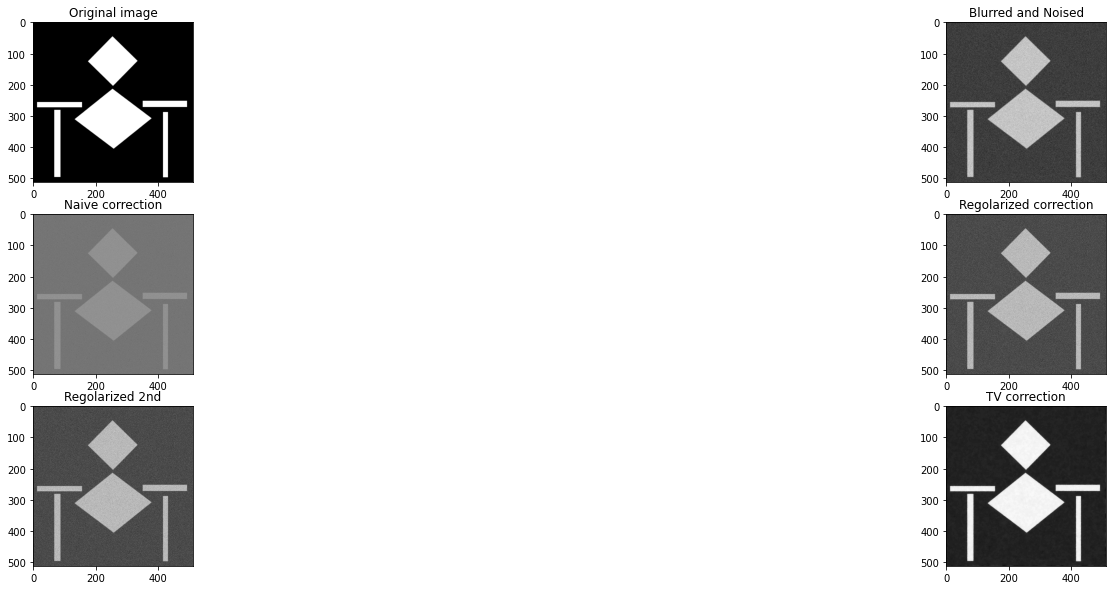

In [3]:
def main(dim_kernel, sigma, std_dev, lambda_value, iteration, img_name):
  
  x0 = np.zeros((512, 512))

  ''' --- PUNTO 1 --- '''

  # Caricamento dell'immagine
  img = plt.imread(f"sample{img_name}.png").astype(np.float64)
  # Generazione del filtro di blur
  K = psf_fft(gaussian_kernel(dim_kernel, sigma), dim_kernel, x0.shape)
  # Generazione del rumore
  noise = np.random.normal(size = x0.shape) * std_dev
  # Applicazione del filtro di blur e del rumore
  blurred = A(img, K)
  noised = blurred + noise


  ''' --- PUNTO 2 --- '''

  # Funzioni da minimizzare calcolando una soluzione Naive
  def f_naive(x):
      X = x.reshape(512, 512)
      res = 0.5 * (np.linalg.norm(A(X, K) - noised)) ** 2
      return res

  def df_naive(x):
      X = x.reshape(512, 512)
      res = AT(A(X, K) - noised, K)
      res2 = np.reshape(res, 512 * 512)
      return res2

  # Ricostruzione dell'immagine usando il metodo del gradiente coniugato implementato dalla funzione minimize di libreria
  res = minimize(f_naive, x0, method='CG', jac=df_naive, options={'maxiter': 100})
  img_naive = res.x.reshape(512, 512)



  ''' --- PUNTO 3 --- '''

  # Funzioni da minimizzare con il termine di regolarizzazione di Tikhonov
  def f_reg(x):
      X = x.reshape(512, 512)
      res = 0.5 * (np.linalg.norm(A(X, K) - noised)) ** 2 + (lambda_value / 2) * (np.linalg.norm(X) ** 2)
      return res

  def df_reg(x):
      X = x.reshape(512, 512)
      res = AT(A(X, K) - noised, K) + (lambda_value * X)
      res2 = np.reshape(res, 512*512)
      return res2

  # Ricostruzione dell'immagine utilizzando il metodo del gradiente coniugato, la funzione minimize di libreria
  # e il termine di regolarizzazione di Tikhonov
  res = minimize(f_reg, x0, method='CG', jac=df_reg, options={'maxiter': 100})
  img_reg = res.x.reshape(512, 512)

  # Ricostruzione dell'immagine utilizzando utilizzando il metodo del gradiente illustrato a lezione e il termine di regolarizzazione di Tikhonov
  (img_reg_2, norm_g_list, fun_eval_list, errors, iterations) = custom_minimize(x0, noised, 100, 1.e-5, f_reg, df_reg)



  ''' --- PUNTO 4 --- '''

  # Funzioni da minimizzare con Variazione Totale
  def f_totvar(x):
      X = x.reshape(512, 512)
      res = 0.5 * (np.linalg.norm(A(X, K) - noised)) ** 2 + (lambda_value * totvar(X))
      return res

  def df_totvar(x):
      X = x.reshape(512, 512)
      res = AT(A(X, K) - noised, K) + (lambda_value * grad_totvar(X))
      res2 = np.reshape(res, 512 * 512)
      return res2

  # Ricostruzione dell'immagine utilizzando il metodo del gradiente implementato a lezione
  # e come termine di regolarizzazione la funzione di "Variazione Totale"
  (img_totvar, norm_g_list_totvar, fun_eval_list_totvar, errors_totvar, iterations_totvar) = totvar_minimize(x0, noised, 100, 1.e-5, f_totvar, df_totvar)


  # Esempio di plotting di un grafico per il confronto di due dei metodi usati.
  # Ulteriori grafici sono riportati e commentati nella relazione allegata.

  """ 
  plt.plot(norm_g_list[1:])
  plt.plot(norm_g_list_totvar[1:])
  plt.legend(['Tikhonov', 'TotVar'])
  plt.xlabel('Iterazioni')
  plt.ylabel('Andamento della norma')
  plt.title('Iterazioni & Andamento della norma del gradiente')
  plt.show()
  plt.savefig('Tikh_TotVar_Geometrica.png', dpi=300)
  """

  # Calcolo (e salvataggio su file) di PSNR e MSE
  calc_PSNR_MSE(iteration, img, noised, img_naive, img_reg, img_reg_2, img_totvar, img_name)

  # Plotting delle immagini ottenute
  plot_figure(img, noised, img_naive, img_reg, img_reg_2, img_totvar)


if __name__ == "__main__":
  # Utilizzando tale funzione ( main ) possiamo settare i valori sottostanti per effettuare tutti i test sulle immagine caricate.

  dim_kernel = [5, 7, 9]
  ker_sigma = [0.5, 1, 1.3]
  sigma = [0.01, 0.02, 0.03, 0.04, 0.05]
  lambda_value = [0.01, 0.05, 0.08, 0.32, 1]

  # Il booleano serve per attivare o meno i test sull'intero dataset; per eseguire test su una singola immagine del
  # dataset è sufficiente impostarlo a False.
  all_tests = False

  if all_tests:
      for img in range(10):
          for i in range(len(dim_kernel)):
              for j in range(len(sigma)):
                  for q in range(len(lambda_value)):
                      options = f"K{i + 1}_{sigma[j]}_{lambda_value[q]}"
                      main(dim_kernel[i], ker_sigma[i], sigma[j], lambda_value[q], options, img + 1)
  else:
      main(dim_kernel[0], ker_sigma[0], sigma[4], lambda_value[2], 'K1_0.05_0.08', '1')
